# Cluster workflow BSG - Hierarchical

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import obspy
import os
import sys
import h5py
import yaml
import sys
import glob
import datetime
import matplotlib.gridspec as gridspec

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

sys.path.append('src/')
from notebook_functions import lagWF, calcMom, calcRadius, upper_tri_masking, latlon2meter, plotCircle,linearizeFP,plotWF, getWF,calcCCMatrix,getFeatures_Explore
from notebook_functions import  plotStem3,plotDepthZoom7,calcCCMatrixFP,calcCCMatrix,plotClusWF4,plotClusWF5,plotCCDistancesfromMat
from notebook_functions import plotLocZoom4, formatWS2021,ClusterExpand4,ClusterConverge2,getNumberInWS21,getProportionWS21,RemoveMagnitudes


from obspy.signal.cross_correlation import correlate, xcorr_max

# Define functions

In [17]:

def makeWfTemplate(cat_clus,dataH5_path,station,channel,fmin,fmax,tmin,tmax,fs=100):
    """
    Get largest magnitude event from cluster and get its WF
    """
    
    magMax = np.max(cat_clus.magnitude)
    
    evID = cat_clus[cat_clus.magnitude==magMax].event_ID.iloc[0]
    
    wf = getWF(evID,dataH5_path,station,channel,fmin,fmax,tmin,tmax,fs)

    
    return wf
    
def ClusterConverge3(cat_expanded,dataH5_path,station,channel,fmin,fmax,tmin,tmax,verbose=1):
    
    # Part 6. Converge clusters

    clus_list_all = np.unique(cat_expanded.Cluster)

    clus_converge = pd.DataFrame()

    for i, clus in enumerate(clus_list_all):

        if verbose:
            if i%10==0:
                print(i,'/',len(clus_list_all))

         ## get df of clusters   
        cat_clusA = cat_expanded[cat_expanded.Cluster==clus]

        ## Location Centroid
        lon_ar = np.array(cat_clusA.long)
        lat_ar = np.array(cat_clusA.lat)
        centroidA = (np.median(lat_ar),np.median(lon_ar))
        
        magA = np.median(cat_clusA.magnitude)

        for j, clus in enumerate(clus_list_all):
            if i!= j:
                
                
                cat_clusB = cat_expanded[cat_expanded.Cluster==clus]

                
                magB = np.median(cat_clusB.magnitude)
                
                
                if np.abs(magA-magB) <= .3:


                    ## Location Centroid
                    lon_ar = np.array(cat_clusB.long)
                    lat_ar = np.array(cat_clusB.lat)
                    centroidB = (np.median(lat_ar),np.median(lon_ar))   

                    centroid_dist_m = latlon2meter((centroidA[0],centroidA[1]),(centroidB[0],centroidB[1]))## args in lat lon

                    med_mag = np.median([np.median(cat_clusA.magnitude),np.median(cat_clusB.magnitude)])

                    dist_thresh = calcRadius(med_mag)

                    if centroid_dist_m < dist_thresh: #m            

                        wf_A = makeWfTemplate(cat_clusA,dataH5_path,station,channel,fmin,fmax,tmin,tmax)
                        wf_B = makeWfTemplate(cat_clusB,dataH5_path,station,channel,fmin,fmax,tmin,tmax)

                        cc = correlate(wf_A, wf_B, 1000)
                        lag, max_cc = xcorr_max(cc)

                        if max_cc >= .95:
        #                     print('adding cluster', clus)
                            clusA = cat_clusA.Cluster.iloc[0]
                            cat_clusA = cat_clusA.append(cat_clusB)
                            cat_clusA.loc[:,'Cluster'] = clusA


                    clus_converge = clus_converge.append(cat_clusA).drop_duplicates('event_ID')    

    print('converged')
    return clus_converge



# Set parameteres and paths

In [9]:

#quarter pagea
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

In [18]:
lenData = 1000 #samples

yamlPath = "./SA_REQS_BSG.yaml"
with open(yamlPath) as stream:
    config = yaml.safe_load(stream)
    
    
path_config = config["paths"]
key = path_config["key"]
data_config = config['dataParams']
station = data_config["station"]
channel = data_config["channel"]
channel_ID = data_config["channel_ID"]
sampling_rate = data_config["sampling_rate"]

# build path strings
dataH5_name = f'data_{key}.h5'
projectPath = path_config["projectPath"]
pathCatFold = path_config["pathCatFold"]


pathWF = path_config["pathWF"]
wf_cat_out_path = projectPath + f'{key}_wf_cat_out.csv'

if not os.path.isdir(projectPath + 'data/H5files/'):
    os.mkdir(projectPath + 'data/H5files/')
    
dataH5_path = projectPath + 'data/H5files/' + dataH5_name
    
sgram_config = config["sgramParams"]
nfft = sgram_config["nfft"]
fmin, fmax = sgram_config["fmin"], sgram_config["fmax"]
tmin, tmax = sgram_config["tmin"], sgram_config["tmax"]

SpecUFEx_H5_name = 'SpecUFEx_' + path_config["h5name"] #f'SpecUFEx_{key}.hdf5'
SpecUFEx_H5_path = projectPath + 'data/H5files/' + SpecUFEx_H5_name


pathWf_cat  = projectPath + 'wf_cat_out.csv'

# get sgram params
with h5py.File(dataH5_path,'r+') as fileLoad:
    # ## sampling rate, Hz
    fs = fileLoad[f"{station}/processing_info"].get('sampling_rate_Hz')[()]
    # ##number of datapoints
    lenData = fileLoad[f"{station}/processing_info"].get('lenData')[()]
    
##spectrogram parameters, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
nperseg = int(sgram_config["winLen_Sec"]*fs) #datapoints per window segment
noverlap = int(nperseg*sgram_config["fracOverlap"])  #fraction of window overlapped  

#padding must be longer than n per window segment
if nfft < nperseg:
    nfft = nperseg*2
    print("nfft too short; changing to ", nfft)

mode='magnitude'
scaling='spectrum'

# set args for generator
args = {'station':station,
        'channel':channel,
        'fs': fs,
        'lenData': lenData,
        'nperseg': nperseg,
        'noverlap': noverlap,
        'nfft': nfft,
        'mode': mode,
        'scaling': scaling,
        'fmin': fmin,
        'fmax': fmax,
        'tmin':tmin,
        'tmax':tmax}

# Load SpecUFEx catalog

In [12]:
cat_keep_sgram = pd.read_csv(pathCatFold + f'{key}_cat_keep_sgram.csv')


len(cat_keep_sgram)


3637

# Load NCEDC and WS2021 catalogs

In [15]:
cat_NCSN = pd.read_csv('../data/catalogs/NCADDiff_5km_2019_500mFault_WS21.csv')

str(cat_NCSN.event_ID.iloc[-1]) 

'73321901'

In [16]:
pathCat = '../data/catalogs/NCA_REPQcat_20210919_noMeta_v2.csv'

cat_rep_2014_df =  formatWS2021(pathCat)

cat_WS21 = cat_NCSN[cat_NCSN.event_ID.astype('int').isin(list(cat_rep_2014_df.event_ID))]

print(len(cat_WS21))

27674 repeater earthquakes in 7714  sequences
1024


# Linearize FPs

In [7]:
ev_IDs = list(cat_keep_sgram.event_ID)


X = linearizeFP(SpecUFEx_H5_path,ev_IDs) #event IDs needed to get fp from H5



col_names = ['fp' + str(a) for a in range(X.shape[1])]
col_names[-1]

fp_df = pd.DataFrame(X,columns=col_names)
fp_df['ev_ID'] = [str(ev) for ev in ev_IDs]
fp_df['event_ID'] = [str(ev) for ev in ev_IDs]

# format event IDs and add lat lon etc to fingerprint catalog
cat_keep_sgram['event_ID'] = [str(ev) for ev in cat_keep_sgram.event_ID]
fp_df = fp_df.merge(cat_keep_sgram,on='event_ID',suffixes=['','_y'])

N = len(fp_df)

print(X.shape)


(3637, 225)


In [8]:
N_list = np.arange(800,N,150)
len(N_list)

19

In [9]:
def latlon2meter_vec(coords1, coords2):
    # Vectorize distance calculation using numpy broadcasting
    lat1, lon1 = np.radians(coords1)
    lat2, lon2 = np.radians(coords2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = (np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = 6371000 * c
    return distance

In [10]:


Nclus_list = []
Ncrit_clus_list = []
Ncrit_cat_list = []
Ncrit_ev_list = []
k_list  = []
Ncrit_ev_list_exp = []
Ncrit_cat_list_exp = []
Ncrit_cat_list_conv = []

# for dT_test in dT_list:
for n in N_list:
    model = AgglomerativeClustering(distance_threshold=None, 
                                n_clusters=n,
                                linkage='ward')

    cluster_labels_best = model.fit_predict(X)

    Z = hierarchy.linkage(model.children_, 'ward')

    nClust = len(np.unique(cluster_labels_best))
    Nclus_list.append(nClust)
    print('N:', n)

    fp_df['Cluster'] = cluster_labels_best




    ########################################################  




######## Check each cluster for criteria ##########################################
######### Check each cluster for criteria ##########################################
######### Check each cluster for criteria ##########################################


    Nclus = len(np.unique(cluster_labels_best))

    repeater_clus = []
    catAllClusAll = pd.DataFrame()

    # Cache median longitude and latitude outside of the loop
    lon_all = np.array(fp_df.long)
    lat_all = np.array(fp_df.lat)

    for i, clus in enumerate(range(Nclus)):

        catAllClus_full = fp_df.where(fp_df.Cluster==clus).dropna()
        catAllClus = RemoveMagnitudes(catAllClus_full, verbose=0)

        if len(catAllClus) >= 2:

            lon_ar = np.array(catAllClus.long)
            lat_ar = np.array(catAllClus.lat)

            # Cache centroid calculation
            centroid_lat = np.median(lat_ar)
            centroid_lon = np.median(lon_ar)
            centroid = (centroid_lat, centroid_lon)

            # Vectorize distance calculation
            dist_m_list = latlon2meter_vec((lat_ar, lon_ar), centroid)

            mag_max = np.max(catAllClus.magnitude)        
            r_m = calcRadius(mag_max)

            if np.max(dist_m_list) <= r_m*2:

                #keep cluster!!
                repeater_clus.append(clus)

                catAllClusAll = catAllClusAll.append(catAllClus) 
                Kopt = len(repeater_clus)   
            else:
                Kopt = 0 

    Ncrit_clus_list.append(Kopt)
    Ncrit_ev_list.append(len(catAllClusAll))
    Ncrit_cat_list.append(catAllClusAll)    
    print('num crit events:', len(catAllClusAll))

    clust_expanded = ClusterExpand4(catAllClusAll, fp_df,lenData,dataH5_path, station,channel,fmin,fmax,tmin,tmax,sampling_rate,verbose=0)

    Ncrit_ev_list_exp.append(len(clust_expanded))    
    Ncrit_cat_list_exp.append(clust_expanded)
    print('expanded num crit events:', len(clust_expanded))
    
    
#     clust_converged = ClusterConverge2(clust_expanded,dataH5_path,station,channel,fmin,fmax,tmin,tmax,verbose=0)

#     Ncrit_cat_list_conv.append(clust_converged)
#     print('converged num crit events:', len(clust_converged))    
    

os.system("say 'program complete'")
print('doneDONEdone')

N: 800
num crit events: 2207
done
expanded num crit events: 2374
N: 950
num crit events: 2279
done
expanded num crit events: 2437
N: 1100
num crit events: 2349
done
expanded num crit events: 2513
N: 1250
num crit events: 2393
done
expanded num crit events: 2547
N: 1400
num crit events: 2397
done
expanded num crit events: 2538
N: 1550
num crit events: 2369
done
expanded num crit events: 2516
N: 1700
num crit events: 2296
done
expanded num crit events: 2453
N: 1850
num crit events: 2232
done
expanded num crit events: 2393
N: 2000
num crit events: 2162
done
expanded num crit events: 2339
N: 2150
num crit events: 2033
done
expanded num crit events: 2233
N: 2300
num crit events: 1904
done
expanded num crit events: 2122
N: 2450
num crit events: 1754
done
expanded num crit events: 1989
N: 2600
num crit events: 1583
done
expanded num crit events: 1832
N: 2750
num crit events: 1389
done
expanded num crit events: 1621
N: 2900
num crit events: 1195
done
expanded num crit events: 1409
N: 3050
num 

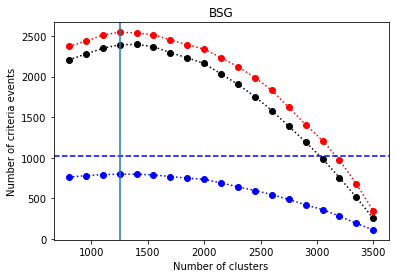

In [11]:
### Plot Proportions

NWS21 = len(cat_WS21)
cat_WS21.event_ID = cat_WS21.event_ID.astype(str)

prop_list = [NWS21*getProportionWS21(Ncrit_cat_list[i].drop_duplicates('event_ID'),cat_WS21) for i in range(len(Ncrit_cat_list))]

plt.figure()

# arg_star = np.argwhere(Ncrit_ev_list==np.max(Ncrit_ev_list))[0][0]
arg_star = np.argwhere(Ncrit_ev_list_exp==np.max(Ncrit_ev_list_exp))[0][0]

arg_star2 = np.argwhere(prop_list==np.max(prop_list))[0][0]



Nstar = N_list[arg_star]


plt.plot(N_list,Ncrit_ev_list,'k:',marker='o')
plt.plot(N_list,Ncrit_ev_list_exp,'r:',marker='o')


plt.plot(N_list,prop_list,'b:',marker='o')

ax = plt.gca()
ax.axhline(NWS21,color='b',ls='--')
ax.axvline(Nstar)



ax.set_xlabel('Number of clusters')
ax.set_ylabel('Number of criteria events')
plt.title(f"{station}")
plt.savefig(f"../reports/figures/clustering_paramSearch_{station}_updatedCat.png")





In [12]:




cat_star_expand = Ncrit_cat_list_exp[arg_star]
cat_star_converged = ClusterConverge3(cat_star_expand,dataH5_path,station,channel,fmin,fmax,tmin,tmax,verbose=0)
cat_star_converged.to_csv(f"../data/catalogs/{key}_updatedCat_MaxExp_WSloc_2.csv")


os.system("say 'program complete'")
print('done')


converged
done
